## Prerequisities

In [24]:
### If hasn't installed already
# !pip install pandas
# !pip install catboost
# !pip install sklearn
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn

In [1]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Loading Data

In [25]:
k2 = pd.read_csv('k2pandc_2025.09.26_11.17.56.csv', comment='#')

## Feature Selection

In [3]:
drop_cols = [
            # not needed
            "default_flag",
            "disc_year",
            "pl_refname",
            "pl_name", 
            "hostname", 
            "disp_refname",
            "pl_orbperlim",
            "st_refname",
            "st_radlim",
            "sy_refname",
            "rastr",
            "ra",
            "decstr",
            "dec",
            "sy_disterr1",
            "sy_disterr2",
            "sy_vmagerr1",
            "sy_vmagerr2",
            "sy_kmagerr1",
            "sy_kmagerr2",
            "sy_gaiamagerr1",
            "sy_gaiamagerr2",
            "rowupdate",
            "pl_pubdate",
            "releasedate",
    
            # too much missing
            "pl_bmassjerr1",
            "st_raderr2",
            "pl_insollim",
            "st_logg",
            "st_meterr2",
            "pl_eqtlim",
            "pl_insol",
            "pl_radelim",
            "pl_radjerr1",
            "st_spectype",
            "pl_eqterr1",
            "pl_bmassjerr2",
            "st_loggerr1",
            "st_tefferr1",
            "st_masslim",
            "st_teff",
            "pl_radjerr2",
            "pl_bmassj",
            "pl_orbsmax",
            "pl_eqt",
            "pl_orbeccenlim",
            "pl_radeerr2",
            "pl_orbeccenerr2",
            "pl_orbsmaxerr1",
            "pl_orbeccen",
            "pl_bmasseerr1",
            "st_meterr1",
            "pl_insolerr1",
            "pl_eqterr2",
            "st_loggerr2",
            "pl_orbpererr1",
            "pl_orbeccenerr1",
            "st_masserr2",
            "pl_radeerr1",
            "pl_orbsmaxerr2",
            "st_tefflim",
            "st_masserr1",
            "pl_orbpererr2",
            "pl_bmasse",
            "pl_bmassprov",
            "pl_insolerr2",
            "st_logglim",
            "pl_radj",
            "pl_orbsmaxlim",
            "st_tefferr2",
            "pl_bmasselim",
            "pl_radjlim",
            "st_metlim",
            "st_raderr1",
            "st_mass",
            "st_metratio",
            "pl_bmassjlim",
            "pl_bmasseerr2",
            "pl_rade",
            "st_met" 
    ]

sel_cols = [
        'disposition',
        'sy_snum', 
        'sy_pnum', 
        'discoverymethod', 
        'disc_facility', 
        'soltype', 
        'pl_controv_flag', 
        'pl_orbper', 
        'ttv_flag', 
        'st_rad', 
        'sy_dist', 
        'sy_vmag', 
        'sy_kmag', 
        'sy_gaiamag'
]

## Label Mapping

In [4]:
label_map = {
    'CONFIRMED': 1,   # Confirmed Planet
    'CANDIDATE': 0,   # Planetary Candidate
    'FALSE POSITIVE': -1,  # False Positive
    'REFUTED': -1   # False Alarm
}

method_map = {
    'Transit': 2,
    'Radial Velocity': 1,
    'Microlensing': 0
}

'''
spectral_map = {
    'K3': 0, 'G': 1, 'G8': 2, 'K5': 3, 'K0': 4, 'K2': 5, 'M4': 6, 'F8': 7, 'K7': 8,
    'G2': 9, 'G3': 10, 'F0': 11, 'G5': 12, 'G7': 13, 'G1': 14, 'G9': 15, 'M0': 16,
    'G0': 17, 'M3': 18, 'K4': 19, 'G4': 20, 'F2': 21, 'F7': 22, 'G5 V': 23, 'M5': 24,
    'M2': 25, 'M1': 26, 'A III': 27, 'F5 V': 28, 'F5': 29, 'F9': 30, 'F6': 31, 'G6': 32,
    'G8 IV/V': 33, 'M2.5 V': 34, 'K6 V': 35, 'K7 V': 36, 'K5 V': 37, 'F': 38, 'G0 V': 39,
    'G V': 40, 'K0 V': 41, 'F6 V': 42, 'K1': 43, 'F9 IV': 44, 'K3 V': 45, 'M1.0 V': 46,
    'M1.5 V': 47, 'M1 V': 48, 'K5.5': 49, 'M3 V': 50, 'G8 V': 51, 'K1 V': 52, 'G6 V': 53,
    'M3.0 V': 54, 'M0.0 V': 55, 'G9 V': 56, 'K2 V': 57, 'M0.0': 58, 'M0 V': 59, 'F9 V': 60,
    'G2 V': 61, 'M0.5 V': 62, 'M4.5': 63, 'M4.5 V': 64, 'G7 IV/V': 65, 'G7 V': 66, 'G3 V': 67,
    'M V': 68, 'M0.0&plusmn;0.5 V': 69, 'M(3.5+/-0.5) V': 70, 'M3.3': 71, 'K4 V': 72,
    'M4 V': 73, 'M5 V': 74, 'K7.5 V': 75, 'G4 V': 76, 'M3.0': 77, 'F8 V': 78, 'G0 IV': 79,
    'K6': 80, 'K3.5 V': 81
}
'''

facility_map = {
    "K2": 0,
    "HATNet": 1,
    "HATSouth": 2,
    "Multiple Observatories": 3,
    "Roque de los Muchachos Observatory": 4,
    "CHaracterising ExOPlanets Satellite (CHEOPS)": 5,
    "La Silla Observatory": 6,
    "Qatar": 7,
    "SuperWASP-South": 8,
    "SuperWASP": 9
}

sol_map = {
    "Published Confirmed": 1.0,
    "Published Candidate": 0.0
}

k2["disposition"] = k2["disposition"].map(label_map)
k2["discoverymethod"] = k2["discoverymethod"].map(method_map)
#k2['st_spectype'] = k2['st_spectype'].map(spectral_map)
k2["disc_facility"] = k2["disc_facility"].map(facility_map)
k2["soltype"] = k2["soltype"].map(sol_map)

### Removing Duplicates

In [26]:
k2 = k2[k2["default_flag"] == 1]

### Selecting Features

In [6]:
k2 = k2.drop(columns=drop_cols)

### Filling empty cells

In [7]:
for col in ["discoverymethod", "disc_facility", "soltype"]:
    if k2[col].isnull().any():
        k2.fillna({col: k2[col].mode()[0]}, inplace=True)

k2 = k2.fillna(k2.mean()) 

### Diagnoise if want

In [45]:
#print(k2.shape[0])
#print(k2["disposition"].unique())
#print(k2.dtypes)
#np.isnan(k2).sum()
#k2.head()

['disposition', 'sy_snum', 'sy_pnum', 'discoverymethod', 'disc_facility', 'soltype', 'pl_controv_flag', 'pl_orbper', 'ttv_flag', 'st_rad', 'sy_dist', 'sy_vmag', 'sy_kmag', 'sy_gaiamag']


# Defining data sets

In [8]:
X = k2.drop("disposition", axis=1)
y = k2["disposition"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
    )

## Defining Classes

In [10]:
classes = np.unique(y_train)

## Calculating Class Weights

In [11]:
weights = compute_class_weight("balanced", classes=classes, y=y_train)

### Combining both

In [12]:
class_weights = dict(zip(classes, weights))

## Cross-validation

In [13]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, valid_idx in skf.split(X, y):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

# Cat Boost Initiation

## Parameters


In [15]:
model = CatBoostClassifier(
    iterations=2500,
    depth=8,
    learning_rate=0.04,
    loss_function="MultiClass",
    eval_metric="MultiClass",
    l2_leaf_reg=5,
    early_stopping_rounds=50,
    random_seed=42,
    verbose=50,
    class_weights=class_weights
)

# Training

In [16]:
model.fit(X_train, y_train, eval_set=(X_test, y_test))

0:	learn: 1.0588491	test: 1.0582245	best: 1.0582245 (0)	total: 198ms	remaining: 8m 13s
50:	learn: 0.4665006	test: 0.4674665	best: 0.4674665 (50)	total: 725ms	remaining: 34.8s
100:	learn: 0.3602734	test: 0.3664778	best: 0.3664778 (100)	total: 1.23s	remaining: 29.1s
150:	learn: 0.3175225	test: 0.3287006	best: 0.3287006 (150)	total: 1.75s	remaining: 27.3s
200:	learn: 0.2872521	test: 0.3063253	best: 0.3063253 (200)	total: 2.25s	remaining: 25.8s
250:	learn: 0.2586573	test: 0.2863401	best: 0.2862477 (249)	total: 2.78s	remaining: 24.9s
300:	learn: 0.2367845	test: 0.2698584	best: 0.2698584 (300)	total: 3.29s	remaining: 24.1s
350:	learn: 0.2171202	test: 0.2562283	best: 0.2562283 (350)	total: 3.83s	remaining: 23.4s
400:	learn: 0.1991196	test: 0.2454383	best: 0.2454383 (400)	total: 4.32s	remaining: 22.6s
450:	learn: 0.1843869	test: 0.2355689	best: 0.2354600 (449)	total: 4.83s	remaining: 21.9s
500:	learn: 0.1715838	test: 0.2285539	best: 0.2285539 (500)	total: 5.33s	remaining: 21.3s
550:	learn: 0.1

## Plotting Loss

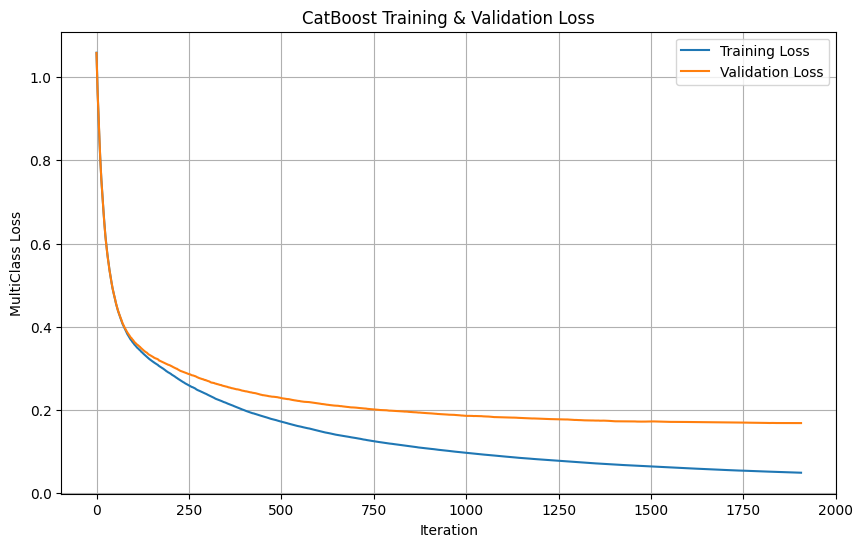

In [17]:
evals_result = model.get_evals_result()

train_loss = evals_result['learn']['MultiClass']
valid_loss = evals_result['validation']['MultiClass']

plt.figure(figsize=(10,6))
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('MultiClass Loss')
plt.title('CatBoost Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation

In [18]:
y_pred = model.predict(X_test)

## Confusion Matrix

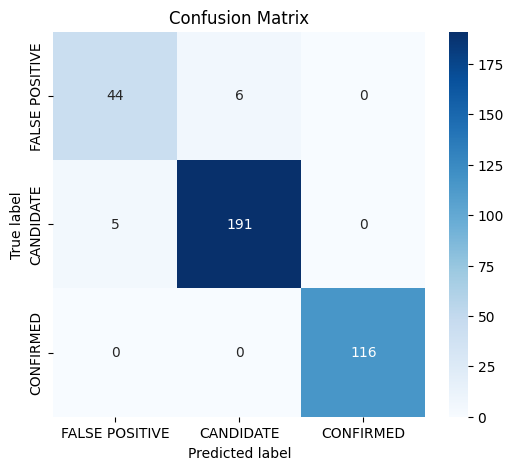

In [19]:
cm = confusion_matrix(y_test, y_pred)

class_names = ["FALSE POSITIVE", "CANDIDATE", "CONFIRMED"]

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

## Accuracy

In [20]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(acc * 100))

Accuracy: 96.96%


# Saving Model

In [22]:
model.save_model("k2_model.onnx", format="onnx")